# Exercise Sheet 2: Binary Classification

### Import necessary libraries

In [32]:
import numpy as np
from math import sqrt
from random import randint
import os
from typing import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from scipy.stats import mode

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 4.0)

import pprint
pp = pprint.PrettyPrinter(indent=4)

# set default theme
sns.set_theme()

In [33]:
RESULTS_PATH_T1 = 'results/task1'
RESULTS_PATH_T2 = 'results/task2'
RESULTS_PATH_T3 = 'results/task3'

## Task 1: k-NearestNeighbours

In [34]:
# create random colours
def generate_colors(amount: int) -> list:
    colors = []
    for i in range(amount):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    return colors

In [35]:
def scatter_2D(x1, x2, y, cdict = {0: 'red', 1: 'blue'}, title='', path='./result/'):

    # if path does not exist, create it
    if not os.path.exists(path):
        os.makedirs(path)

    img_name = title.replace(' ', '_')
    img_path = path + img_name

    fig, ax = plt.subplots()
    for g in np.unique(y):
        ix = np.where(y == g)
        ax.scatter(x1[ix], x2[ix], c=cdict[g], marker='.', label=f'class {g}')
    ax.legend()
    plt.gca().set_aspect('equal', adjustable='box')  # set aspect ratio to be equal
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

    fig.savefig(img_path, dpi=fig.dpi)

In [36]:
def scatter_2D_linspace(x1, x2, y, cdict={0: 'red', 1: 'blue'}, title='', path='./result/', line_x=np.linspace(0, 1), line_y=np.linspace(0, 1), xlim=None, ylim=None):

    # if path does not exist, create it
    if not os.path.exists(path):
        os.makedirs(path)

    img_name = title.replace(' ', '_')
    img_path = path + img_name

    fig, ax = plt.subplots(figsize=(8, 6))  # Set the figure size explicitly
    # plotting three dimensional functions
    # use meshgrid
    X, Y = np.meshgrid(line_x, line_y)
    Z1 = np.exp(X * Y)
    # Z1 = X ** 2 + (Y - X) * 2  # log scale
    z = np.ma.masked_where(Z1 <= 0, Z1)

    cs = plt.contourf(X, Y, z,
                      locator=ticker.LogLocator(),
                      cmap="bone")

    for g in np.unique(y):
        ix = np.where(y == g)
        ax.scatter(x1[ix], x2[ix], c=cdict[g], marker='.', label=f'class {g}', zorder=1)
    ax.legend()

    # Plot the resulting regression line
    plt.plot(line_x, line_y, '-', color='r', zorder=1)

    # Define area to plot
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(cs)

    # Set xlim and ylim if provided
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()  # Optimize the layout and remove unnecessary white space
    plt.show()

    fig.savefig(img_path, dpi=fig.dpi)


In [37]:
def calc_rss(y, y_pred):
    """Calculate minimal RSS Error"""
    return np.sum(np.square(y - y_pred))

In [38]:
def calc_accuracy(y, ypred):
    """Calculate the accuracy score."""
    return np.mean(y==ypred)

### k-Nearest Neighbour Algorithm

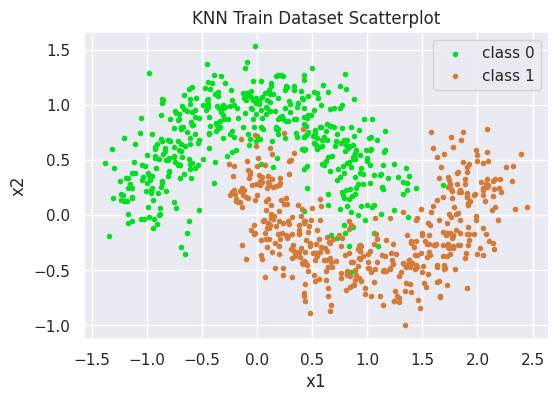

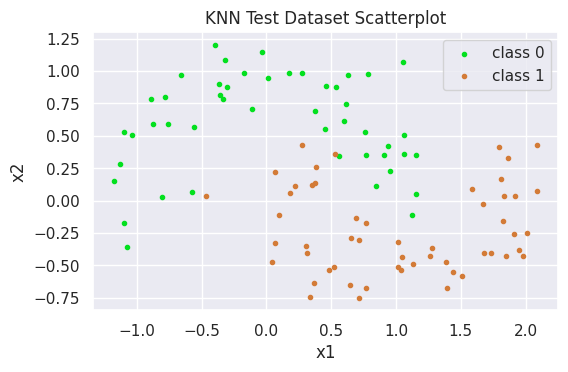

In [39]:
# 1. Visualize the dataset
import sklearn.datasets


N = 1000
N_train = int(N*0.9) #use 90% for training
N_test = N - N_train #rest for testing

# 2D dataset consisting of points x and binary labels y
x, y = sklearn.datasets.make_moons(n_samples=N, noise=0.2,random_state=0)

# create data
#split into train and test set
xtrain, ytrain = x[:N_train,...], y[:N_train,...]
xtest, ytest = x[N_train:,...], y[N_train:,...]

# randomly generate colour dict
labels = np.unique(ytrain)
colors = generate_colors(len(labels))
cdict_ = dict(zip(labels, colors))

scatter_2D(xtrain[0:,0], xtrain[0:,1], ytrain, cdict=cdict_, title='KNN Train Dataset Scatterplot', path=RESULTS_PATH_T1)
scatter_2D(xtest[0:,0], xtest[0:,1], ytest, cdict=cdict_, title='KNN Test Dataset Scatterplot', path=RESULTS_PATH_T1)


In [40]:
def euclidean_distance(vec1, vec2):
    """ Distance metric to define the similarity of two vectors

        Calculate the Euclidean distance between two vectors.
        >> Euclidean Distance = sqrt(sum i to N (x1_i – x2_i)^2)
        As the data points are vectors the norm can be calculated.
    """
    # return np.sqrt(np.sum((vec1-vec2)**2))
    return np.linalg.norm(vec1 - vec2) # vectorized

In [41]:

class KNN:
    """ Does not require any learning as the model stores the entire dataset
        and classifies data points based on the points that are similar to it.
        It makes predictions based on the training data only.
    """
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit(self, x, y):
        self.x = x
        self.y = y

    def kneighbors(self, xquery):
        """ Returns the indices and distances of the k nearest neighbor points
            based on distances to them. Uses the euclidean distance as distance metric.
        """
        point_dist = []
        for i in range(len(self.x)):
            dist = euclidean_distance(xquery, self.x[i])
            point_dist.append((i, dist))
        point_dist.sort(key=lambda x: x[1])
        indices = np.array([x[0] for x in point_dist[:self.n_neighbors]])
        distances = np.array([x[1] for x in point_dist[:self.n_neighbors]])
        return indices, distances

    def predict(self, xquery):
        """ Returns predicted label for a given query point.
        """
        predictions = []
        for i in range(len(xquery)):
            indices, _ = self.kneighbors(xquery[i])
            pred_labels = self.y[indices.astype(int)]
            # calc mode to get most occuring values
            pred_mode_label = int(mode(pred_labels)[0])
            # np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=pred_labels)
            predictions.append(pred_mode_label)
        return predictions

    def predict_probs(self, xquery):
        """Returns class probabilities for a given query point."""
        xquery = np.atleast_2d(xquery)

        # Get indices of k-nearest neighbors for all query points
        indices, _ = self.kneighbors(xquery)

        # Get labels of k-nearest neighbors
        neighbor_labels = self.y[indices]

        # Calculate class frequencies for each query point
        class_freqs = [Counter(neighbor_label) for neighbor_label in neighbor_labels.reshape(-1, self.n_neighbors)]

        # Convert frequencies to probabilities
        class_probas = np.array([[freq / self.n_neighbors for freq in freqs.values()] for freqs in class_freqs])

        return class_probas

    def predict_grid(self, xx, yy):
        """ Returns predicted labels for a grid of points. """
        grid = np.c_[xx.ravel(), yy.ravel()]
        predictions = self.predict(grid)
        predictions_array = np.array(predictions)
        return predictions_array.reshape(xx.shape)


In [42]:
# 2. Fit your KNN model for k = 5 to the data

k = 5

# own version
knn = KNN(n_neighbors=k)

# sklearn version
sknn = KNeighborsClassifier(n_neighbors=k)

# fit the model
knn.fit(xtrain, ytrain)
sknn.fit(xtrain, ytrain)

# 3. Predict the labels of the test data
y_pred  = knn.predict(xtest)
print(f"KNN predictions: \n{y_pred}\n")

y_pred_sk = sknn.predict(xtest)
print(f"Sklearn KNN predictions: \n{y_pred_sk}\n")

KNN predictions: 
[1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]

Sklearn KNN predictions: 
[1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0
 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1
 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1]



In [43]:
#check if our implementation is equal to that one from scikit-learn
print("Are results equal: ", (y_pred == y_pred_sk).all())

Are results equal:  True


In [13]:
# 4. Compare the predicted labels with the true labels
print('Own KNN\n')
print(classification_report(ytest, y_pred))

Own KNN

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        47
           1       0.98      0.96      0.97        53

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [14]:
print('Sklearn KNN\n')
print(classification_report(ytest, y_pred_sk))

Sklearn KNN

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        47
           1       0.98      0.96      0.97        53

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



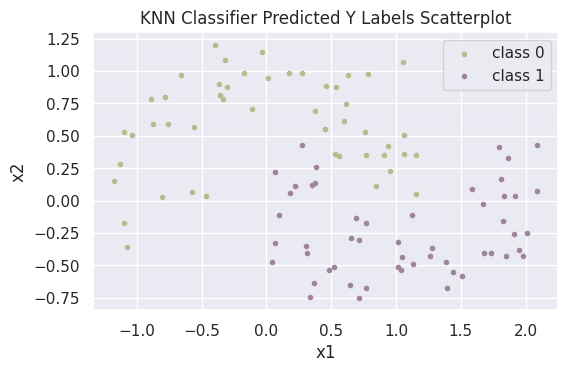

In [15]:
scatter_2D(xtest[0:,0], xtest[0:,1], y_pred, cdict=cdict_, title='KNN Classifier Predicted Y Labels Scatterplot', path=RESULTS_PATH_T1)

KNN with k: 1
The minimum RSS error for KNN is: 6
The minimum accuracy score for KNN is: 0.94


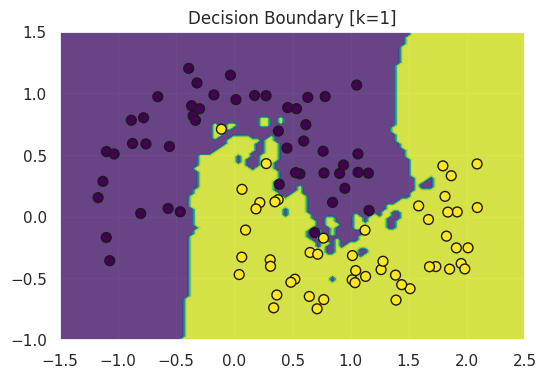

KNN with k: 2
The minimum RSS error for KNN is: 4
The minimum accuracy score for KNN is: 0.96


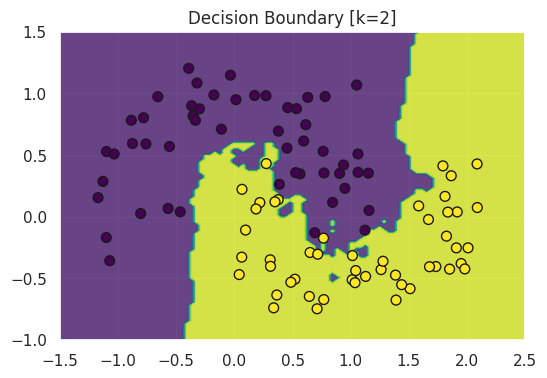

KNN with k: 4
The minimum RSS error for KNN is: 6
The minimum accuracy score for KNN is: 0.94


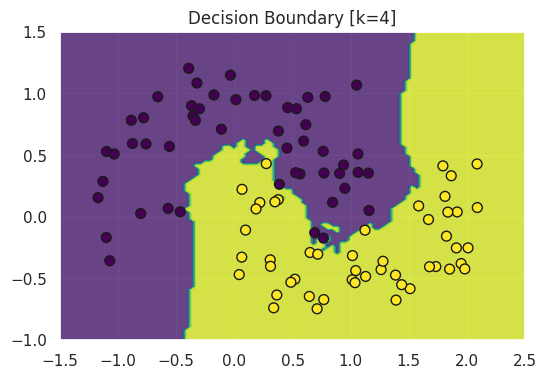

KNN with k: 8
The minimum RSS error for KNN is: 5
The minimum accuracy score for KNN is: 0.95


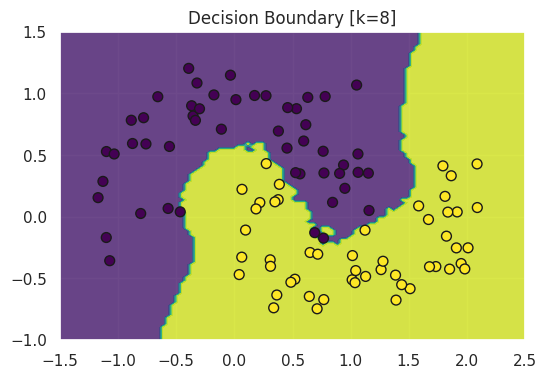

KNN with k: 16
The minimum RSS error for KNN is: 1
The minimum accuracy score for KNN is: 0.99


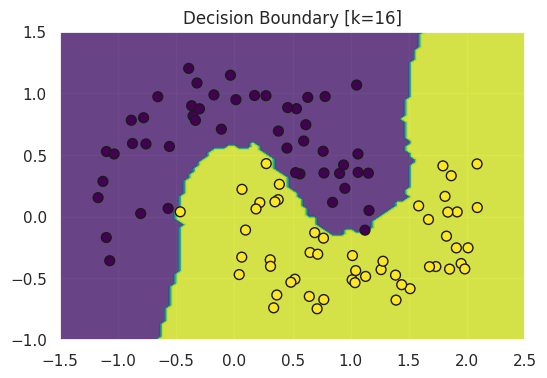

KNN with k: 32
The minimum RSS error for KNN is: 3
The minimum accuracy score for KNN is: 0.97


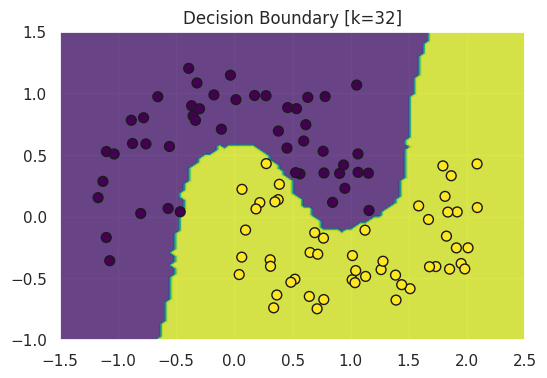

KNN with k: 64
The minimum RSS error for KNN is: 3
The minimum accuracy score for KNN is: 0.97


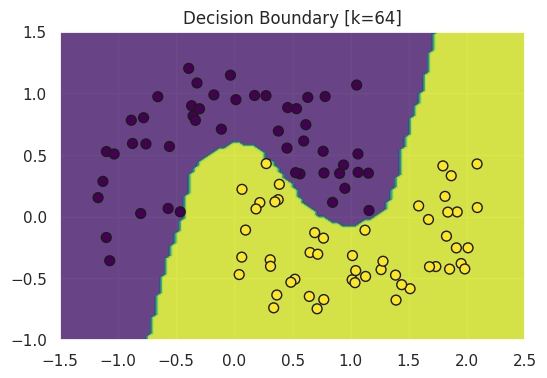

KNN with k: 128
The minimum RSS error for KNN is: 5
The minimum accuracy score for KNN is: 0.95


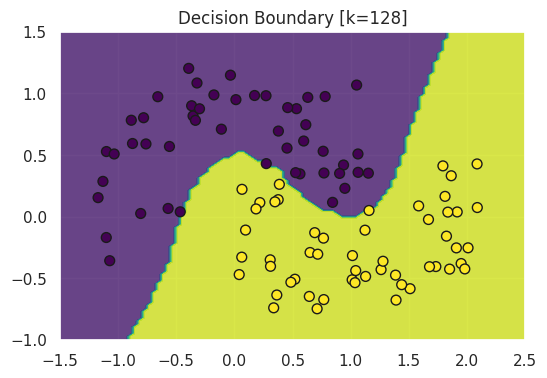

KNN with k: 256
The minimum RSS error for KNN is: 6
The minimum accuracy score for KNN is: 0.94


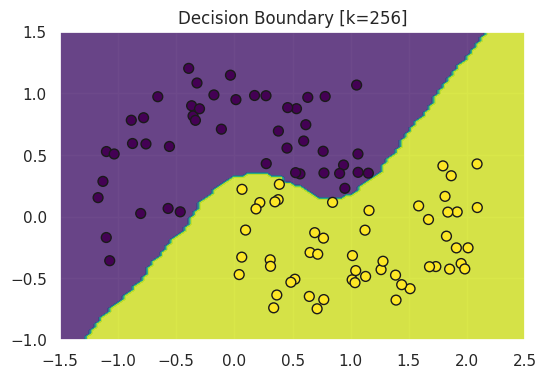

KNN with k: 512
The minimum RSS error for KNN is: 20
The minimum accuracy score for KNN is: 0.8


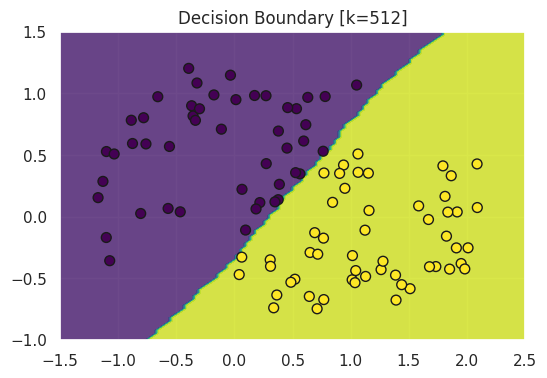

In [16]:
# 5. Analyze different values of k
ks = [pow(2, i) for i in range(10)]
accuracies = []
N = 100

for k in ks:
    print("KNN with k: " + str(k))
    # fit and evaluate accuracy on test data
    knn = KNN(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    knn_ypred = knn.predict(xtest)

    rss = calc_rss(ytest, knn_ypred)
    acc = calc_accuracy(ytest, knn_ypred)
    print("The minimum RSS error for KNN is: " + str(rss))
    print("The minimum accuracy score for KNN is: " + str(acc))

    accuracies.append((k, acc))

    # Plot decision boundary
    linx = np.linspace(-1.5, 2.5, N)
    liny = np.linspace(-1.0, 1.5, N)

    # Create a meshgrid
    xx, yy = np.meshgrid(linx, liny)

    # Predict labels for grid points
    Z = knn.predict_grid(xx, yy)

    # Plot the contourf
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')

    # Plot the data points
    plt.scatter(xtest[:, 0], xtest[:, 1], c=knn_ypred, cmap='viridis', s=50, edgecolor='k')

    plt.title(f'Decision Boundary [k={k}]')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

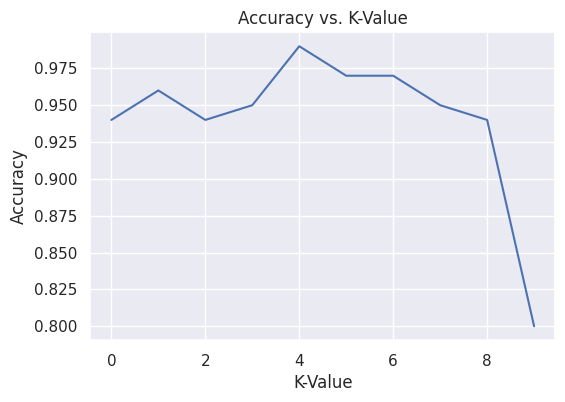

In [17]:
acc_values = [acc for k, acc in accuracies]

# Plot accuracies
plt.plot(acc_values)

# Add title and labels
plt.title('Accuracy vs. K-Value')
plt.xlabel('K-Value')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

7. **How does the decision boundary change with k? What would happen if k is
equal to the number of train samples?**

As the value of k increases, the decision boundary of the classifier becomes softer and more general. This is because a larger k increasingly reduces the influence of individual data points, which leads to a lower variance in the model. However, this also leads to greater distortion, as the model is less sensitive to local patterns and outliers in the data.

Conversely, as the value of k decreases, the decision boundary becomes more complex and more closely aligned with the training data. This increases the variance of the model and makes it more sensitive to noise and outliers, but reduces the distortion.

In the extreme case, where k is equal to the number of training samples, the decision boundary would be perfectly fitted to the training data, resulting in a training error of zero. However, this would lead to severe underfitting since the K-NN would always predict the majority class, which would cause the model to perform poorly on unseen data. In other words, the model would have high variance and low bias, so it would not generalise well to new data.



KNN with k=2
Class probabilities p(c): [0.50444444 0.49555556]
Accuracy: 0.9700


Calculating densities for k=2: 100%|██████████| 10000/10000 [00:05<00:00, 1775.81it/s]



KNN with k=4
Class probabilities p(c): [0.5 0.5]
Accuracy: 0.9656


Calculating densities for k=4: 100%|██████████| 10000/10000 [00:04<00:00, 2023.04it/s]



KNN with k=8
Class probabilities p(c): [0.50180556 0.49819444]
Accuracy: 0.9633


Calculating densities for k=8: 100%|██████████| 10000/10000 [00:04<00:00, 2083.12it/s]



KNN with k=16
Class probabilities p(c): [0.50152778 0.49847222]
Accuracy: 0.9644


Calculating densities for k=16: 100%|██████████| 10000/10000 [00:05<00:00, 1784.53it/s]



KNN with k=32
Class probabilities p(c): [0.4996875 0.5003125]
Accuracy: 0.9667


Calculating densities for k=32: 100%|██████████| 10000/10000 [00:04<00:00, 2058.42it/s]


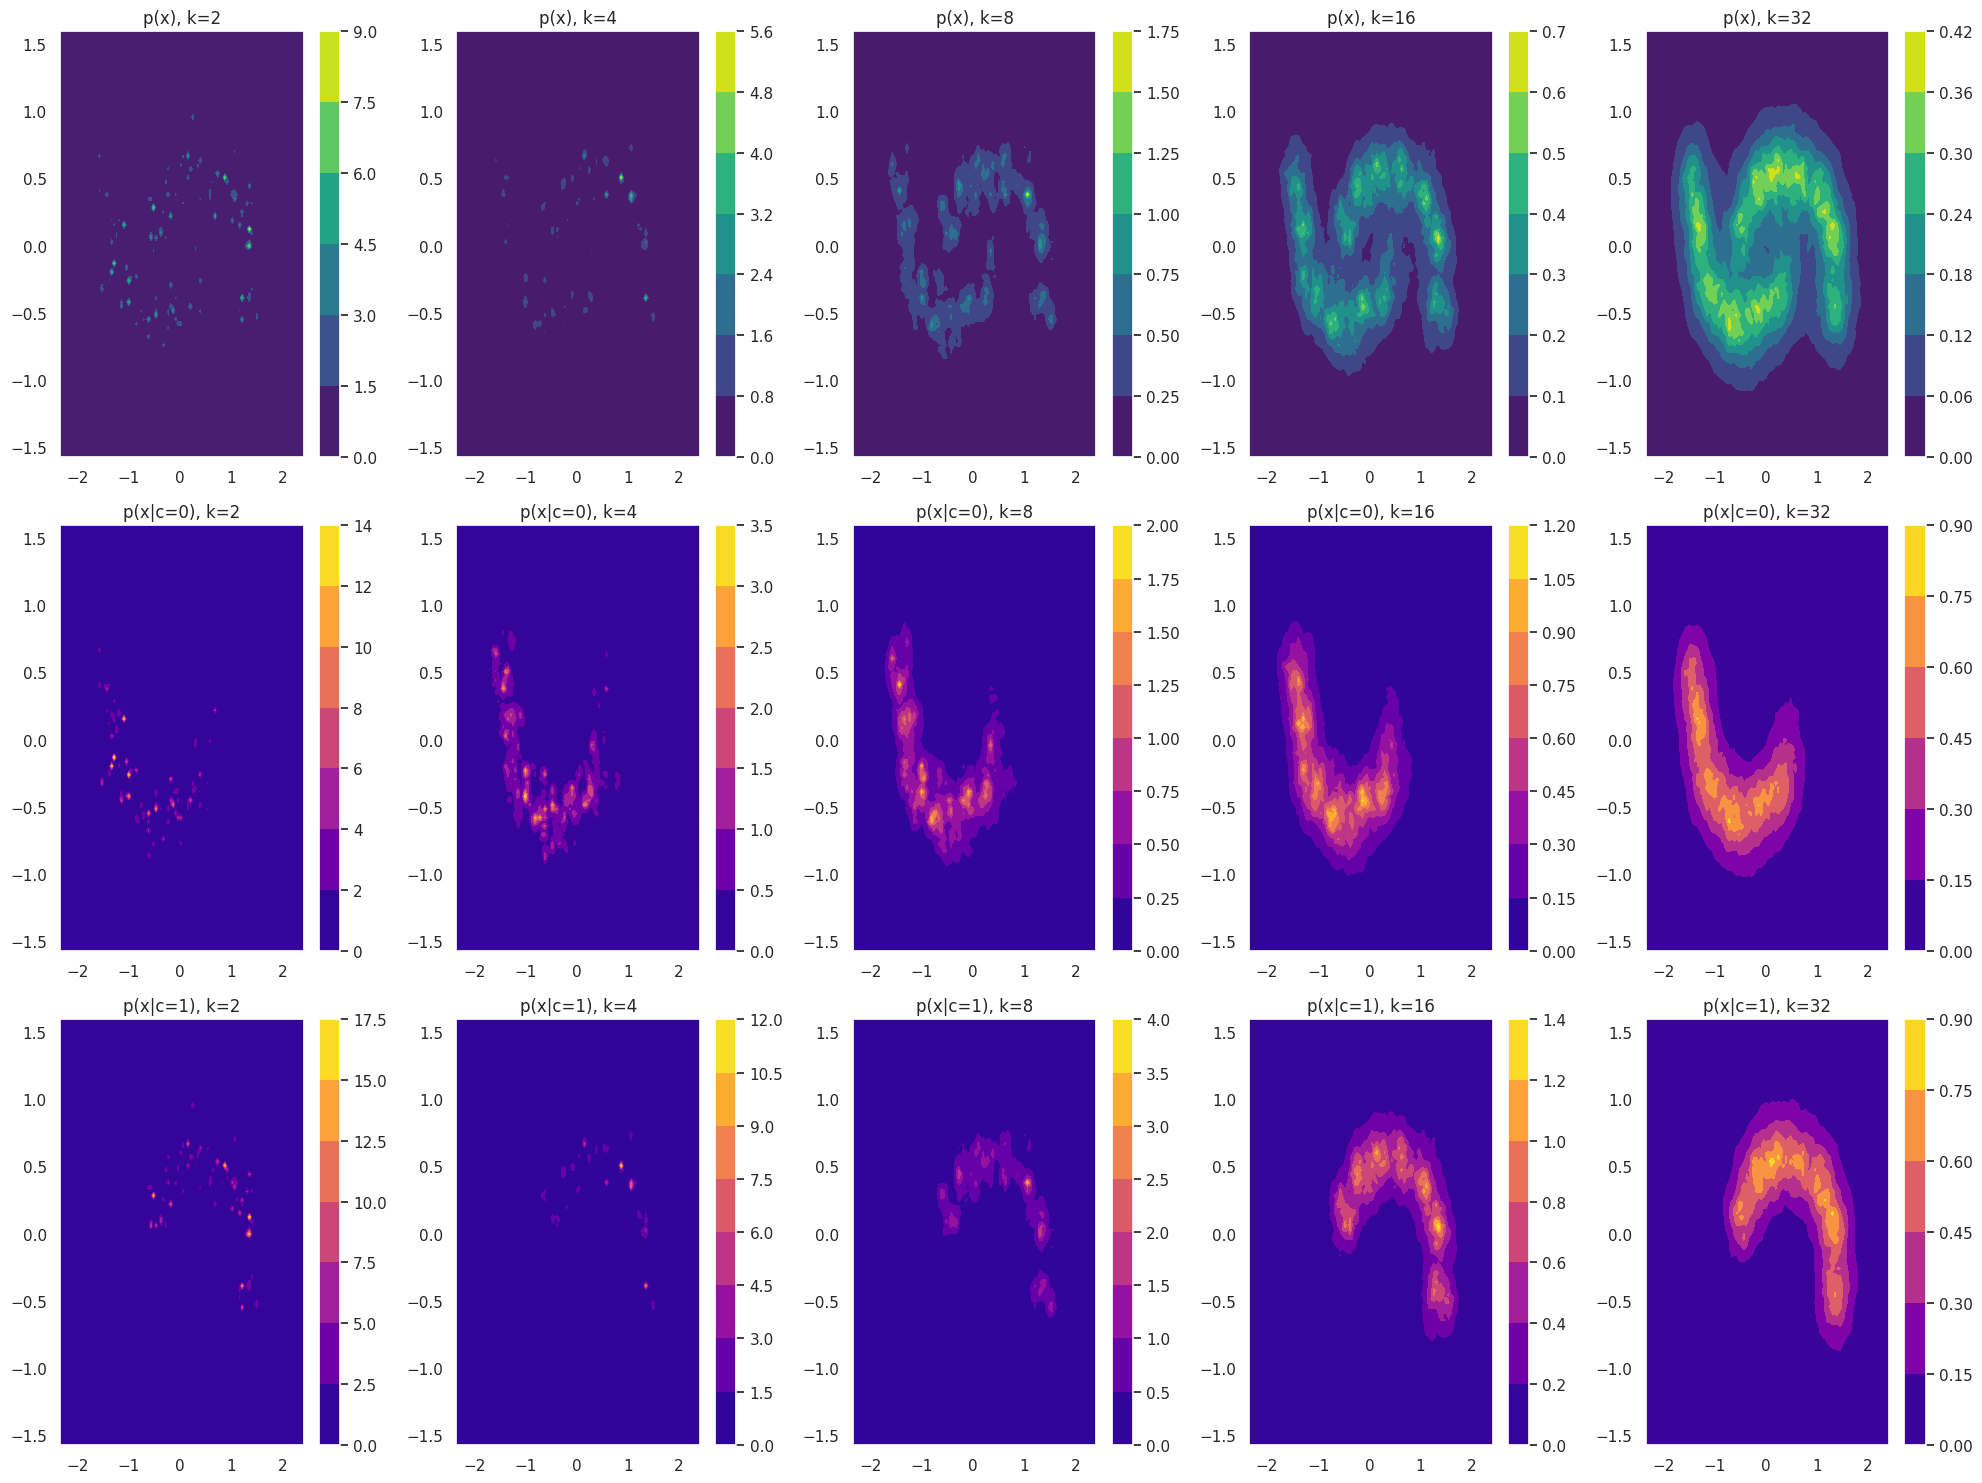

In [50]:
# Task 8:

# Report class probabilities p(c) on the train set.
# Further plot p(xn) = k(N*V*) by estimating V* as the area of the smallest circle needed to include k nearest neighbours for a query point xn.
# Use k = 2,4,8,16,32. Repeat the same plots for p(xn|c)

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from tqdm import tqdm

def plot_density(ax, xx, yy, density, title, cmap='viridis'):
    contf = ax.contourf(xx, yy, density.reshape(xx.shape), cmap=cmap)
    ax.set_title(title)
    return contf

def calculate_densities(knn, X, y, grid_points, k):
    N = len(X)
    n_classes = len(np.unique(y))

    p_xn = np.zeros(len(grid_points))
    p_xn_given_c = np.zeros((len(grid_points), n_classes))

    for j, xn in enumerate(tqdm(grid_points, desc=f"Calculating densities for k={k}")):
        distances, indices = knn.kneighbors([xn])
        V_star = np.pi * distances[0, -1]**2  # Area of smallest circle

        # p(xn)
        p_xn[j] = k / (N * V_star)

        # p(xn|c)
        neighbor_labels = y[indices[0]]
        class_counts = Counter(neighbor_labels)
        for c in range(n_classes):
            k_c = class_counts[c]
            N_c = np.sum(y == c)
            p_xn_given_c[j, c] = k_c / (N_c * V_star) if N_c > 0 else 0

    return p_xn, p_xn_given_c

# Perform PCA for visualization
pca = PCA(n_components=2)
xtrain_2d = pca.fit_transform(xtrain)

# Create a meshgrid for plotting
x1 = np.linspace(xtrain_2d[:, 0].min() - 0.5, xtrain_2d[:, 0].max() + 0.5, 100)
x2 = np.linspace(xtrain_2d[:, 1].min() - 0.5, xtrain_2d[:, 1].max() + 0.5, 100)
xx, yy = np.meshgrid(x1, x2)
grid_points_2d = np.c_[xx.ravel(), yy.ravel()]

# Transform grid points back to original space
grid_points = pca.inverse_transform(grid_points_2d)

ks = [2, 4, 8, 16, 32]
accuracies = []

fig, axes = plt.subplots(3, len(ks), figsize=(20, 15))

for i, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain, ytrain)

    # Report class probabilities p(c) on the train set
    train_probs = knn.predict_proba(xtrain)
    p_c = np.mean(train_probs, axis=0)
    print(f"\nKNN with k={k}")
    print("Class probabilities p(c):", p_c)

    # Calculate accuracy
    y_pred = knn.predict(xtrain)
    accuracy = np.mean(y_pred == ytrain)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy:.4f}")

    # Calculate p(xn) and p(xn|c) for grid points
    p_xn, p_xn_given_c = calculate_densities(knn, xtrain, ytrain, grid_points, k)

    # Plot p(xn)
    contf = plot_density(axes[0, i], xx, yy, p_xn, f"p(x), k={k}")
    plt.colorbar(contf, ax=axes[0, i])

    # Plot p(xn|c=0) and p(xn|c=1)
    for c in range(2):
        contf = plot_density(axes[c+1, i], xx, yy, p_xn_given_c[:, c], f"p(x|c={c}), k={k}", cmap='plasma')
        plt.colorbar(contf, ax=axes[c+1, i])

plt.tight_layout()
plt.savefig("task8_densities.png")

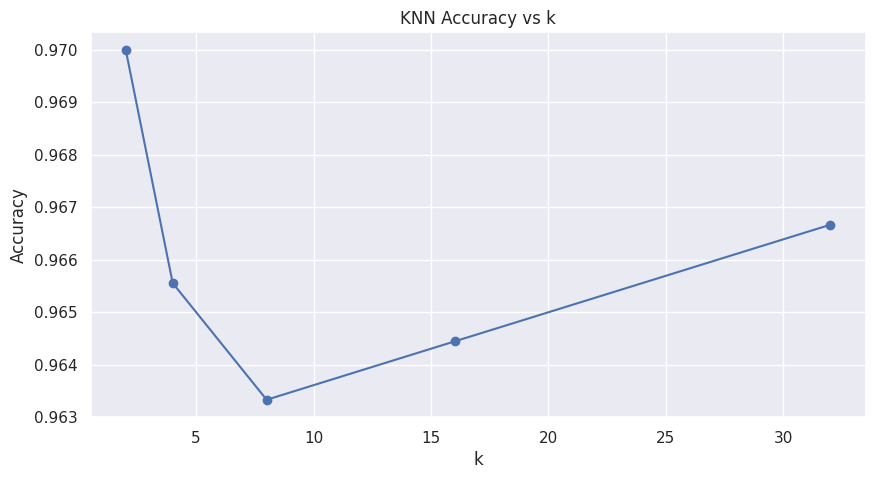

In [49]:

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(ks, accuracies, marker='o')
plt.title('KNN Accuracy vs k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.savefig("task8_accuracies.png")

### Task 2: Linear Regression

In [19]:
def make_data(noise=0.2, outlier=1):
    """ Generate random training dataset with noise """
    prng = np.random.RandomState(0)
    n = 500

    x0 = np.array([0,0])[None,:] + noise*prng.randn(n, 2)
    y0 = np.ones(n)
    x1 = np.array([1,1])[None,:] + noise*prng.randn(n, 2)
    y1 = -1*np.ones(n)

    x = np.concatenate([x0,x1])
    y = np.concatenate([y0,y1]).astype(np.int32)

    xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(
        x, y, test_size=0.1, shuffle=True, random_state=0)
    xplot, yplot = xtrain, ytrain

    outlier = outlier*np.array([1,1.75])[None,:]
    youtlier = np.array([-1])
    xtrain = np.concatenate([xtrain, outlier])
    ytrain = np.concatenate([ytrain, youtlier])
    return xtrain, xtest, ytrain, ytest, xplot, yplot

In [20]:
# 1. Complete the code for the linear least squares regression
class LinearLeastSquares(object):
    """ Implementation of Linear Regression using Least Squares.
        Is a linear approach to modelling the relationship between a dependent
        variable and one or more independent variables.
    """
    def fit(self, x, y):
        """ Normal equation to find a minimizer
            for the least square objective.
            >>> x = independent variable
            >>> y = dependent variable
        """
        # vectors that shall be combined
        # prepend ones to the input to use the bias trick
        m = len(x)
        X_w = np.array([np.ones(m), x[:, 0], x[:, 1]]).T

        # matrix inversion and calculate solution
        self.w = np.linalg.inv(X_w.T.dot(X_w)).dot(X_w.T.dot(y))

        return self.w

    def predict(self, xquery):
        # Concatenate numpy array of ones to predicted y_pred values
        # apply dot product with w to predict y values
        m = len(xquery)
        X_pred = np.array([np.ones(m), xquery[:, 0], xquery[:, 1]]).T

        y_pred = X_pred.dot(self.w)
        y_pred = np.rint(y_pred).astype('int8') # rounds to nearest integer

        return y_pred

Outlier 2:
The RSS error is: 5
The accuracy score is: 0.95


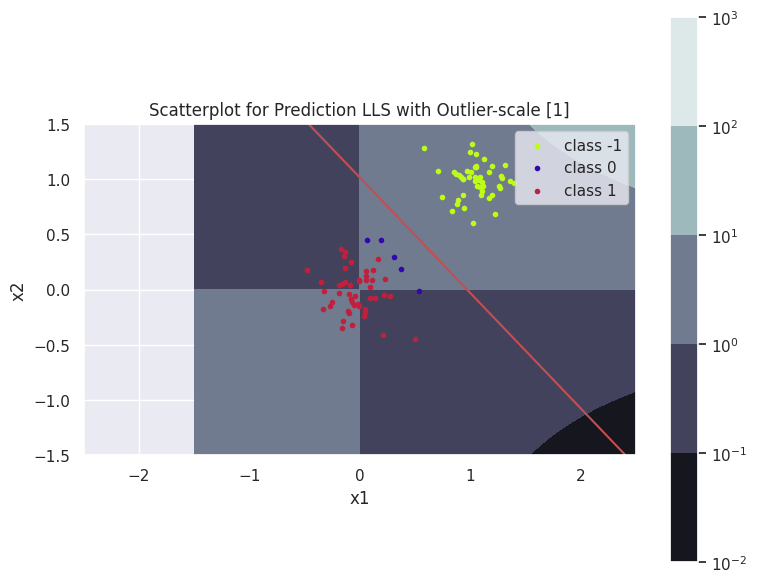

Outlier 3:
The RSS error is: 5
The accuracy score is: 0.95


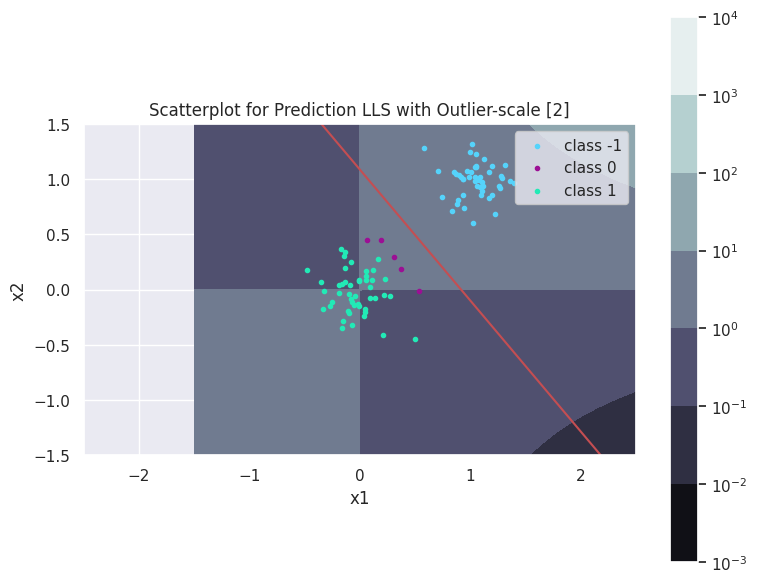

Outlier 5:
The RSS error is: 5
The accuracy score is: 0.95


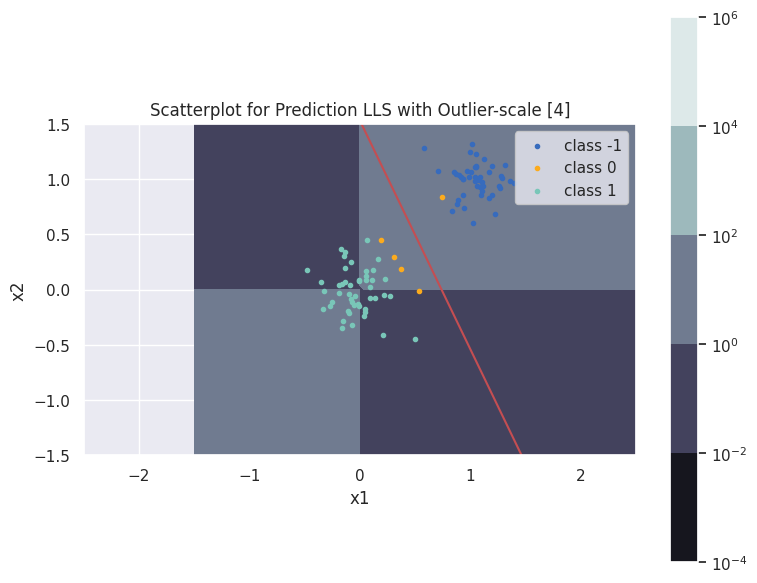

Outlier 9:
The RSS error is: 15
The accuracy score is: 0.85


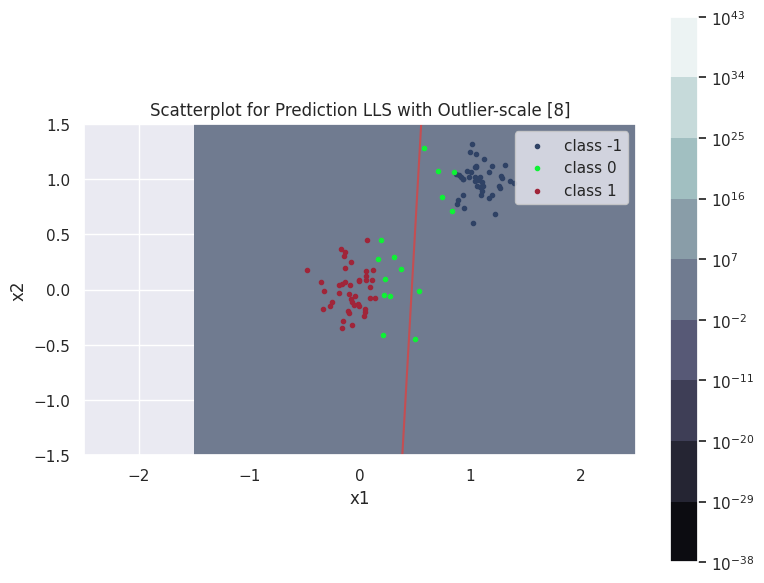

In [21]:
path='./code_task2/result/'
lls = LinearLeastSquares()
n = [2**i for i in range(4)]

for outlier in n:
    # get data. xplot, yplot is same as xtrain, ytrain but without outlier
    xtrain, xtest, ytrain, ytest, xplot, yplot = make_data(outlier=outlier)

    beta = lls.fit(xtrain, ytrain)

    # evaluate accuracy and decision boundary of LLS
    ypred = lls.predict(xtest)

    # randomly generate colour dict
    labels = np.unique(ypred)
    colors = generate_colors(len(labels))
    cdict_ = dict(zip(labels, colors))

    rss = calc_rss(ytest, ypred)
    acc = calc_accuracy(ytest, ypred)

    # Print metrics
    print(f"Outlier {outlier+1}:")
    print("The RSS error is: " + str(rss))
    print("The accuracy score is: " + str(acc))

    title = f'Scatterplot for Prediction LLS with Outlier-scale [{outlier}]'

    # Plot the resulting regression line
    N = 100
    # linx = np.linspace(-1.5, 2.5, N)
    # liny = np.linspace(-1.0, 1.5, N)

    linx = np.linspace(-1.5, 2.5, N)
    liny = -beta[0] / beta[2] - (beta[1] / beta[2]) * linx

    scatter_2D_linspace(xtest[0:,0], xtest[0:,1], ypred, cdict=cdict_, title=title, line_x=linx, line_y=liny, path=RESULTS_PATH_T2, xlim=[-2.5, 2.5], ylim=[-1.5, 1.5])

4. **How is the fit affected by the outlier? Give a short explanation?**

Outliers are observed data points that significantly deviate from the general trend in the dataset, appearing far away from the least squares line. Due to their large vertical distance from the line, outliers have substantial error values (residuals), which can significantly influence the regression equation. This influence is particularly pronounced in small datasets, where a single outlier can considerably impact the overall fit.

When outliers are present, the least squares prediction is shifted towards them, causing the variance of the estimates to be artificially inflated. Consequently, the prediction accuracy decreases as the value of the outliers increases. This effect is evident in the provided plots, where outliers ranging from [1, 16] demonstrate a clear decline in prediction accuracy as their values increase. In summary, outliers can negatively impact the fit of a regression model, leading to reduced prediction accuracy and inflated variance in the estimates.

### Task 3: Softmax Regression & Optimization


1. Derive a formula for the gradient $\frac{\partial L}{\partial \theta_c}$. To do so, derive the solution for a single example $L_i$ and apply the chain rule of calculus $\frac{\partial L}{\partial \theta} = \frac{\partial L}{\partial p} \frac{\partial p}{\partial g} \frac{\partial g}{\partial \theta}$ with $g_j = \theta_{j,0} + \sum_{d=1}^{D} \theta_{j,d} x_d$. Report derivatives of each chain rule component to get full points.

We start with a single element $L_i$ from $L = \sum_{i=1}^N L_i$ as the derivatives for each element are summed up.

The softmax function is defined as:

$$\text{softmax}(g_j) = p_j = \frac{e^{g_j}}{\sum_{k=1}^{C} e^{g_k}}$$

Where:
* $g_j$ is the logit for class $j$.
* $C$ is the total number of classes.

Calculate each component of the chain rule:

(1) $\frac{\partial L}{\partial p_c}$:

The cross-entropy loss for a single example is:

$L = -\sum_{k=1}^C \log(p_k) 1[y=k]$

Therefore:

$\frac{\partial L}{\partial p_c} = -\frac{1}{p_c} 1[y=c]$

Where $1[y=c]$ is the indicator function, equal to 1 if $y=c$ and 0 otherwise.

(2) $\frac{\partial p_c}{\partial g_j}$:

We need to consider two cases:

$$\frac{\partial p_c}{\partial g_j} = p_c(\delta_{cj} - p_j)$$

Where $\delta_{cj}$ is the Kronecker delta:
$\delta_{cj} = \begin{cases} 1, & \text{if } c = j \\ 0, & \text{otherwise} \end{cases}$

This formula encapsulates both cases:
a) When $c = j$: $\frac{\partial p_c}{\partial g_c} = p_c(1 - p_c)$
b) When $c \neq j$: $\frac{\partial p_c}{\partial g_j} = -p_c p_j$

(3) $\frac{\partial g_j}{\partial \theta_{a,d}}$:

$$\frac{\partial g_j}{\partial \theta_{a,d}} = x_d \delta_{aj}$$

Where $x_d$ is the $d$-th feature and $\delta_{aj}$ ensures we only consider the parameters for the $j$-th class.

Combine these components:

\begin{align*}
\frac{\partial L}{\partial \theta_{a,d}} &= \sum_{c=1}^C \frac{\partial L}{\partial p_c} \frac{\partial p_c}{\partial g_j} \frac{\partial g_j}{\partial \theta_{a,d}} \\
&= \sum_{c=1}^C -\frac{1}{p_c} 1[y=c] \cdot p_c(\delta_{cj} - p_j) \cdot x_d \delta_{aj} \\
&= -x_d \delta_{aj} (1[y=j] - p_j)
\end{align*}

This final form gives us the gradient of the loss with respect to each parameter $\theta_{a,d}$. When $a=j$, it simplifies to:

$$\frac{\partial L}{\partial \theta_{j,d}} = -x_d (1[y=j] - p_j)$$

This gradient is used to update the parameters in the direction that minimizes the loss function.


In [22]:
# 3.1 Define stable softmax function
def stable_softmax(logits):
    """ Compute the softmax of vector x in a numerically stable way.
        Prevent overflow and underflow by subtracting the maximum value from the logits.
    """
    logits_max = np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits - logits_max)
    sum_exp_logits = np.sum(exp_logits, axis=1, keepdims=True)
    return exp_logits / sum_exp_logits


In [23]:
def to_classlabel(z):
    """ Convert class probabilities to class labels """
    return z.argmax(axis=1)

def cross_entropy(output, y_target):
    """ Compute the cross entropy loss as cost function.
        Average of all cross entropy losses for N training samples.
    """
    return - np.sum(np.log(output) * (y_target), axis=1)

def cost(output, y_target):
    """ Compute the cost function as the average of all cross entropy losses
        for N training samples.
    """
    return np.mean(cross_entropy(output, y_target))

In [24]:
# 2. Load digits dataset (load_digits) from sklearn.datasets
data = load_digits()
# Normalize and reshape input data
x, y = (data.images / 16.0).reshape(-1, 8 * 8), data.target

# Split the dataset into training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=0)

In [25]:
# 3.3 Implement an optimization routine using gradient descent.

# initialize parameters (10 classes)
weights = np.random.normal(0, 1, size=(10, x.shape[1]))
bias = np.zeros((10,))

# set learning rate and number of iterations
lr = 0.001
num_iterations = 1000

# metrics
losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []

# iterate through number of iterations
for i in range(num_iterations):

    # calculate logits and probabilities
    logits = xtrain @ weights.T + bias
    probs = stable_softmax(logits)

    # One-hot encoded targets
    y_onehot = (np.arange(np.max(ytrain) + 1) == ytrain[:, None]).astype(float)

    # calculate the loss
    train_loss = cross_entropy(probs, y_onehot)

    # calculate the gradient with respect to weights and bias
    grad_weights = xtrain.T @ (probs - y_onehot)
    grad_bias = np.sum(probs - y_onehot, axis=0)

    # update the parameters using gradient descent
    weights -= lr * grad_weights.T
    bias -= lr * grad_bias

    # calculate training accuracy
    train_predictions = np.argmax(probs, axis=1)
    train_accuracy = np.mean(train_predictions == ytrain)

    # calculate test logits, probabilities, and accuracy
    test_logits = xtest @ weights.T + bias
    test_probs = stable_softmax(test_logits)
    test_predictions = np.argmax(test_probs, axis=1)
    test_accuracy = np.mean(test_predictions == ytest)

    # One-hot encoded targets for test set
    ytest_onehot = (np.arange(np.max(ytest) + 1) == ytest[:, None]).astype(float)

    # calculate the loss for test set
    test_loss = cross_entropy(test_probs, ytest_onehot)

    # append metrics
    losses_train.append(train_loss.mean())
    losses_test.append(test_loss.mean())
    accuracies_train.append(train_accuracy)
    accuracies_test.append(test_accuracy)

    # print progress
    if (i + 1) % 100 == 0:
        print(f"Iteration {i + 1}/{num_iterations} -- Train Loss: {train_loss.mean():.4f} -- Train Accuracy: {train_accuracy:.4f} -- Test Loss: {test_loss.mean():.4f} -- Test Accuracy: {test_accuracy:.4f}")

Iteration 100/1000 -- Train Loss: 0.2786 -- Train Accuracy: 0.9280 -- Test Loss: 0.3811 -- Test Accuracy: 0.8844
Iteration 200/1000 -- Train Loss: 0.1802 -- Train Accuracy: 0.9562 -- Test Loss: 0.2647 -- Test Accuracy: 0.9267
Iteration 300/1000 -- Train Loss: 0.1419 -- Train Accuracy: 0.9710 -- Test Loss: 0.2209 -- Test Accuracy: 0.9400
Iteration 400/1000 -- Train Loss: 0.1202 -- Train Accuracy: 0.9755 -- Test Loss: 0.1978 -- Test Accuracy: 0.9422
Iteration 500/1000 -- Train Loss: 0.1056 -- Train Accuracy: 0.9777 -- Test Loss: 0.1836 -- Test Accuracy: 0.9511
Iteration 600/1000 -- Train Loss: 0.0948 -- Train Accuracy: 0.9822 -- Test Loss: 0.1741 -- Test Accuracy: 0.9511
Iteration 700/1000 -- Train Loss: 0.0865 -- Train Accuracy: 0.9837 -- Test Loss: 0.1672 -- Test Accuracy: 0.9489
Iteration 800/1000 -- Train Loss: 0.0797 -- Train Accuracy: 0.9866 -- Test Loss: 0.1621 -- Test Accuracy: 0.9489
Iteration 900/1000 -- Train Loss: 0.0741 -- Train Accuracy: 0.9866 -- Test Loss: 0.1582 -- Test 

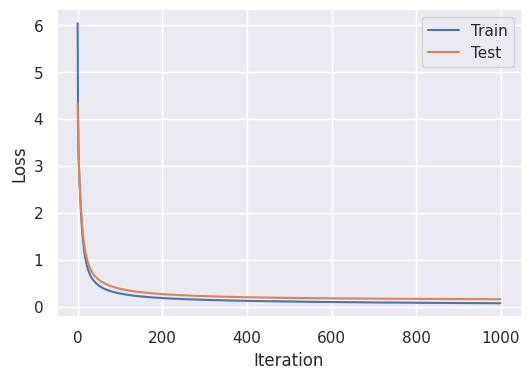

In [26]:
# 3.4 Report the final accuracy on the test set.

# plot the evolution of the losses
plt.plot(losses_train, label='Train')
plt.plot(losses_test, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

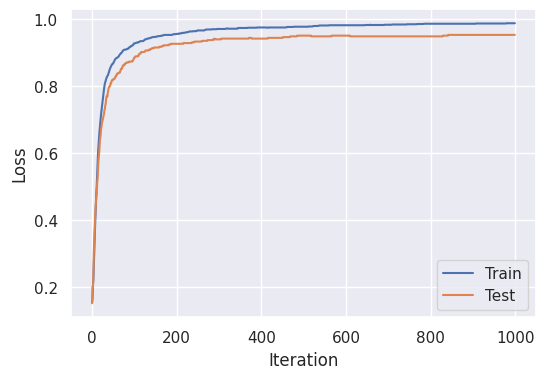

In [27]:
# plot the evolution of the losses
plt.plot(accuracies_train, label='Train')
plt.plot(accuracies_test, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()